# Updating the HLCA with a healthy dataset

In this notebook we will update the human lung cell atlas (HLCA) with a healthy dataset. We will use the latent space created in the [HLCA paper](https://zenodo.org/record/6337966#.YqrznidBx3h). 

This notebook consists of several steps:
1. Training the reference classifier
2. Updating the hierarchy with a healthy dataset
3. Visualizing the latent space & marker genes

Instead of training the reference classifier yourself, you can also download the trained classifier from [Zenodo](https://doi.org/10.5281/zenodo.6786357). There are two classifier here: one trained with the FAISS library and one without. The FAISS library makes the model faster but only works on Linux and with a gpu. More information about installation can be found here: https://anaconda.org/pytorch/faiss-gpu

## 1. Training the reference classifier

In [1]:
import scanpy as sc
import scHPL
import numpy as np
import seaborn as sns
import matplotlib

In [8]:
sc.settings.set_figure_params(dpi=800, frameon=False)
sc.set_figure_params(dpi=800)
sc.set_figure_params(figsize=(4, 4))

matplotlib.rcParams['pdf.fonttype'] = 42

In [4]:
LCA = sc.read('HLCA_emb_and_metadata.h5ad')

In [5]:
# Check how big the cell populations are in each annotation level
print(LCA.obs.groupby(['ann_level_1']).count()['sample'])
print(LCA.obs.groupby(['ann_level_2']).count()['sample'])
print(LCA.obs.groupby(['ann_level_3']).count()['sample'])
print(LCA.obs.groupby(['ann_level_4']).count()['sample'])
print(LCA.obs.groupby(['ann_level_5']).count()['sample'])


ann_level_1
Endothelial     48166
Epithelial     282065
Immune         229436
Stroma          25217
Name: sample, dtype: int64
ann_level_2
Airway epithelium      207253
Alveolar epithelium     70112
Blood vessels           43571
Fibroblast lineage      21100
Lymphatic EC             4595
Lymphoid                74121
Mesothelium               230
Myeloid                155315
Smooth muscle            3887
Submucosal Gland         4700
Name: sample, dtype: int64
ann_level_3
AT1                               7937
AT2                              62175
B cell lineage                    6284
Basal                            84713
Dendritic cells                  10319
EC arterial                       7391
EC capillary                     23205
EC venous                        12975
Fibroblasts                      20384
Fibromyocytes                      335
Innate lymphoid cell NK          16978
Lymphatic EC differentiating       566
Lymphatic EC mature               4001
Lymphatic EC pr

Create hierarchy belonging to the reference atlas based on the different annotation levels.

In [6]:
xx = LCA.obs.groupby(['ann_level_1', 'ann_level_2', 'ann_level_3', 'ann_level_4', 'ann_level_5']).count()['sample']
xx = xx.iloc[xx.values>0]
xx.index[0]

('Endothelial', 'Blood vessels', 'EC arterial', 'None', 'None')

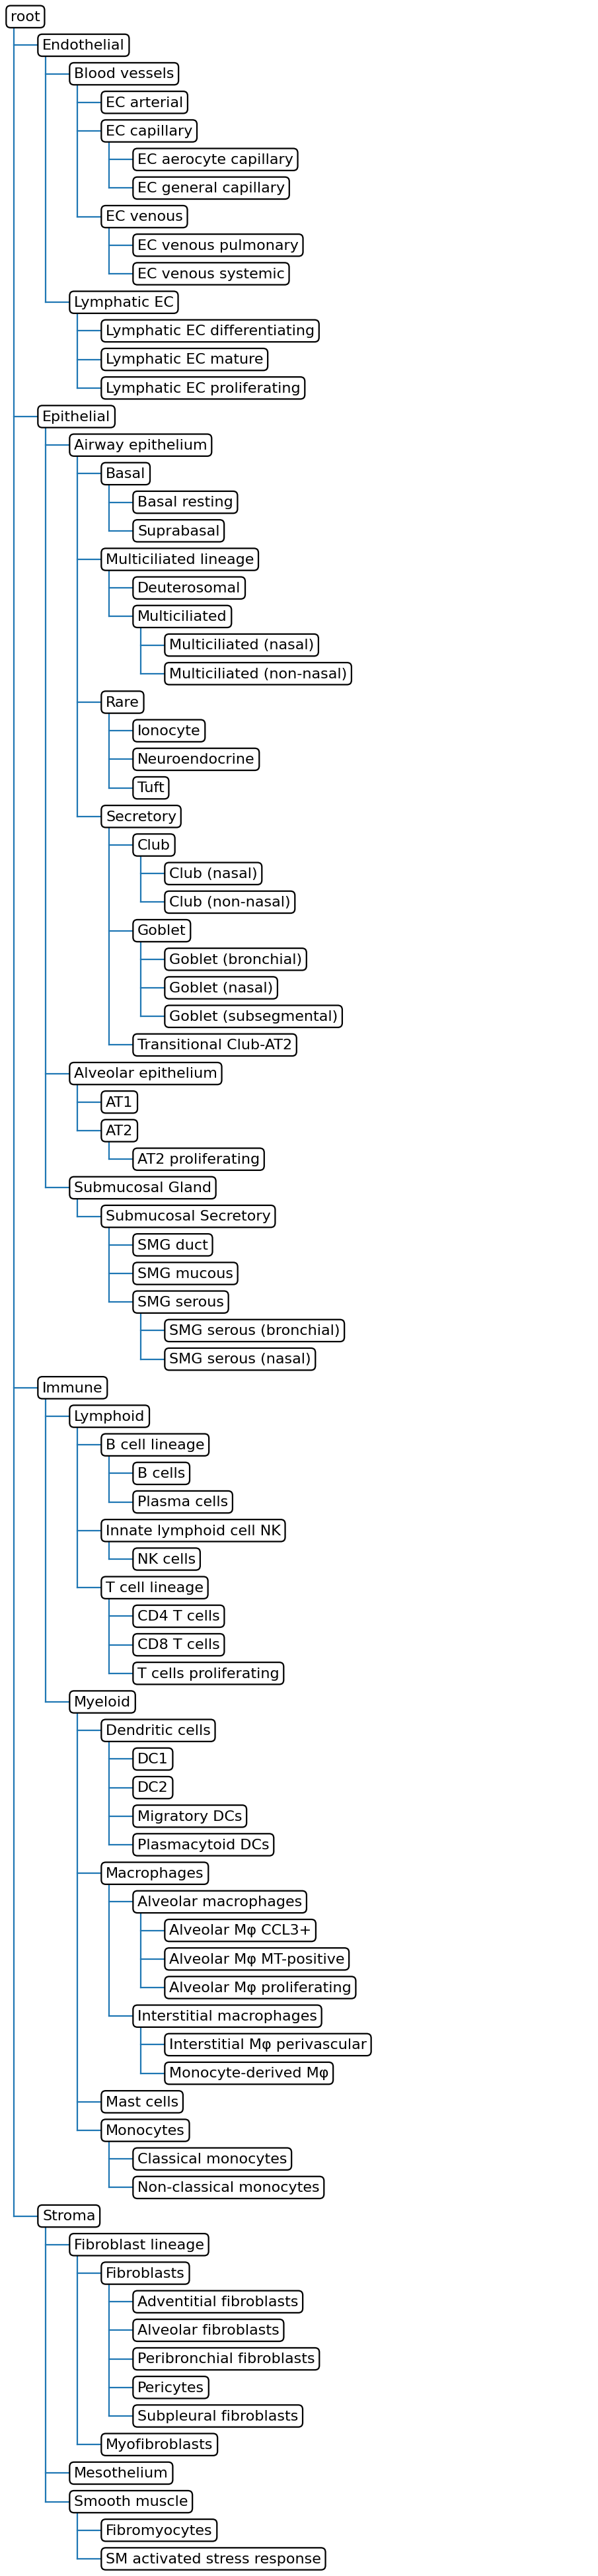

In [9]:
HLCA_tree = scHPL.utils.create_tree('root')

node_added = []
parent1 = None
parent2 = None
parent3 = None
parent4 = None

for ind in xx.index:
    
    for i, ind_sub in enumerate(ind):
        
        if ind_sub == 'None':
            continue
        
        if not np.isin(ind_sub, node_added):
            node_added.append(ind_sub)
            
            newNode = scHPL.utils.TreeNode([ind_sub])
            
            if i == 0:
                HLCA_tree[0].add_descendant(newNode)
                parent1 = newNode
            elif i == 1:
                parent1.add_descendant(newNode)
                parent2 = newNode
            elif i == 2:
                parent2.add_descendant(newNode)
                parent3 = newNode
            elif i == 3:
                parent3.add_descendant(newNode)
                parent4 = newNode
            elif i == 4:
                parent4.add_descendant(newNode)
                
scHPL.utils.print_tree(HLCA_tree)

Now that we have constructed the hierarchy belonging to the reference, we can train the classifier.

In [10]:
HLCA_tree = scHPL.train.train_tree(LCA.X, 
               np.array(LCA.obs.ann_finest_level.values), 
               HLCA_tree, 
               classifier = 'knn', 
               dimred = False, 
               useRE = True, 
               FN = 0.5, 
               n_neighbors = 50, dynamic_neighbors = True)


You can save the tree using pickle if you want to use it later on.

In [12]:
import pickle
 
file_to_store = open("tree_HLCA.pickle", "wb")
pickle.dump(HLCA_tree, file_to_store)
file_to_store.close()

## 2. Update the tree with a healthy dataset

Here, we will update the tree with the Meyer dataset. The latent space for this dataset can be downloaded from [Zenodo](https://zenodo.org/record/6337966#.YqrznidBx3h). The count data for the Meyer dataset can be downloaded here: https://hmgubox.helmholtz-muenchen.de/f/8d3d2158f25b45278ba1/?dl=1

In [13]:
## If you didn't train the tree and want to import it

file_to_read = open("tree_HLCA.pickle", "rb")
HLCA_tree = pickle.load(file_to_read)
file_to_read.close()


Load the two Meyer datasets. We will load the count data for the annotations (and later on we will use this to visualize marker genes) and we load the embeddings for the latent space.

In [20]:
data = sc.read('HLCA_v1_extension_to_share.h5ad')
data_M = data[data.obs['study'] == 'Meyer_2021']
data_M

View of AnnData object with n_obs × n_vars = 128628 × 2000
    obs: 'dataset', 'study', 'condition', 'single_cell_platform', 'cells_or_nuclei', 'subject_ID', 'sample', 'sample_type', 'age', 'sex', 'ethnicity', 'BMI', 'smoking_status', 'anatomical_region_level_1', 'original_ann_nonharmonized', 'original_ann_level_1', 'original_ann_level_2', 'original_ann_level_3', 'original_ann_level_4', 'original_ann_level_5', 'anatomical_region_coarse_unharmonized', 'anatomical_region_detailed_unharmonized', 'transf_ann_level_1', 'transf_ann_level_1_thresholded', 'transf_uncert_level_1', 'transf_ann_level_2', 'transf_ann_level_2_thresholded', 'transf_uncert_level_2', 'transf_ann_level_3', 'transf_ann_level_3_thresholded', 'transf_uncert_level_3', 'transf_ann_level_4', 'transf_ann_level_4_thresholded', 'transf_uncert_level_4', 'transf_ann_level_5', 'transf_ann_level_5_thresholded', 'transf_uncert_level_5'
    obsm: 'X_scanvi_emb'

In [17]:
emb_M3 = sc.read('HLCA_extended_models_and_embs/surgery_output_embeddings/Meyer_2021_3prime_emb_LCAv2.h5ad')
emb_M5 = sc.read('HLCA_extended_models_and_embs/surgery_output_embeddings/Meyer_2021_5prime_emb_LCAv2.h5ad')

Concatenate them and preprocess the labels by adding the batch

In [21]:
emb_M = sc.concat([emb_M3, emb_M5])
emb_M.obs['original_ann_nonharmonized'] = data_M.obs['original_ann_nonharmonized']
emb_M.obs['ct-batch'] = np.char.add(np.char.add(np.array(emb_M.obs['original_ann_nonharmonized'], dtype=str), '-'), 'Meyer')
emb_M.obs['batch'] = 'Meyer'

emb_M

AnnData object with n_obs × n_vars = 128628 × 30
    obs: 'scHPL_pred', 'original_ann_nonharmonized', 'ct-batch', 'batch'

Preprocess the reference such that the metadata is in the same column as the query

In [22]:
LCA.obs['ct-batch'] = LCA.obs['ann_finest_level']
LCA.obs['batch'] = 'Reference'

LCA

AnnData object with n_obs × n_vars = 584884 × 30
    obs: 'sample', 'study_long', 'study', 'last_author_PI', 'subject_ID', 'sex', 'ethnicity', 'mixed_ethnicity', 'smoking_status', 'BMI', 'condition', 'subject_type', 'sample_type', 'single_cell_platform', "3'_or_5'", 'sequencing_platform', 'cell_ranger_version', 'fresh_or_frozen', 'dataset', 'anatomical_region_level_1', 'anatomical_region_level_2', 'anatomical_region_level_3', 'anatomical_region_highest_res', 'age', 'ann_highest_res', 'n_genes', 'log10_total_counts', 'mito_frac', 'ribo_frac', 'original_ann_level_1', 'original_ann_level_2', 'original_ann_level_3', 'original_ann_level_4', 'original_ann_level_5', 'scanvi_label', 'leiden_1', 'leiden_2', 'leiden_3', 'anatomical_region_ccf_score', 'entropy_study_leiden_3', 'entropy_dataset_leiden_3', 'entropy_subject_ID_leiden_3', 'entropy_original_ann_level_1_leiden_3', 'entropy_original_ann_level_2_clean_leiden_3', 'entropy_original_ann_level_3_clean_leiden_3', 'entropy_original_ann_level_4

In [23]:
LCA_Meyer = sc.concat([LCA, emb_M])
LCA_Meyer

AnnData object with n_obs × n_vars = 713512 × 30
    obs: 'ct-batch', 'batch'

In [24]:
## Rename populations such that _ is removed
## Otherwise this messes up plotting of the tree

LCA_Meyer.obs['ct-batch'] = LCA_Meyer.obs['ct-batch'].str.replace('_',' ')

Now, we can update the hierarchy

Starting tree:


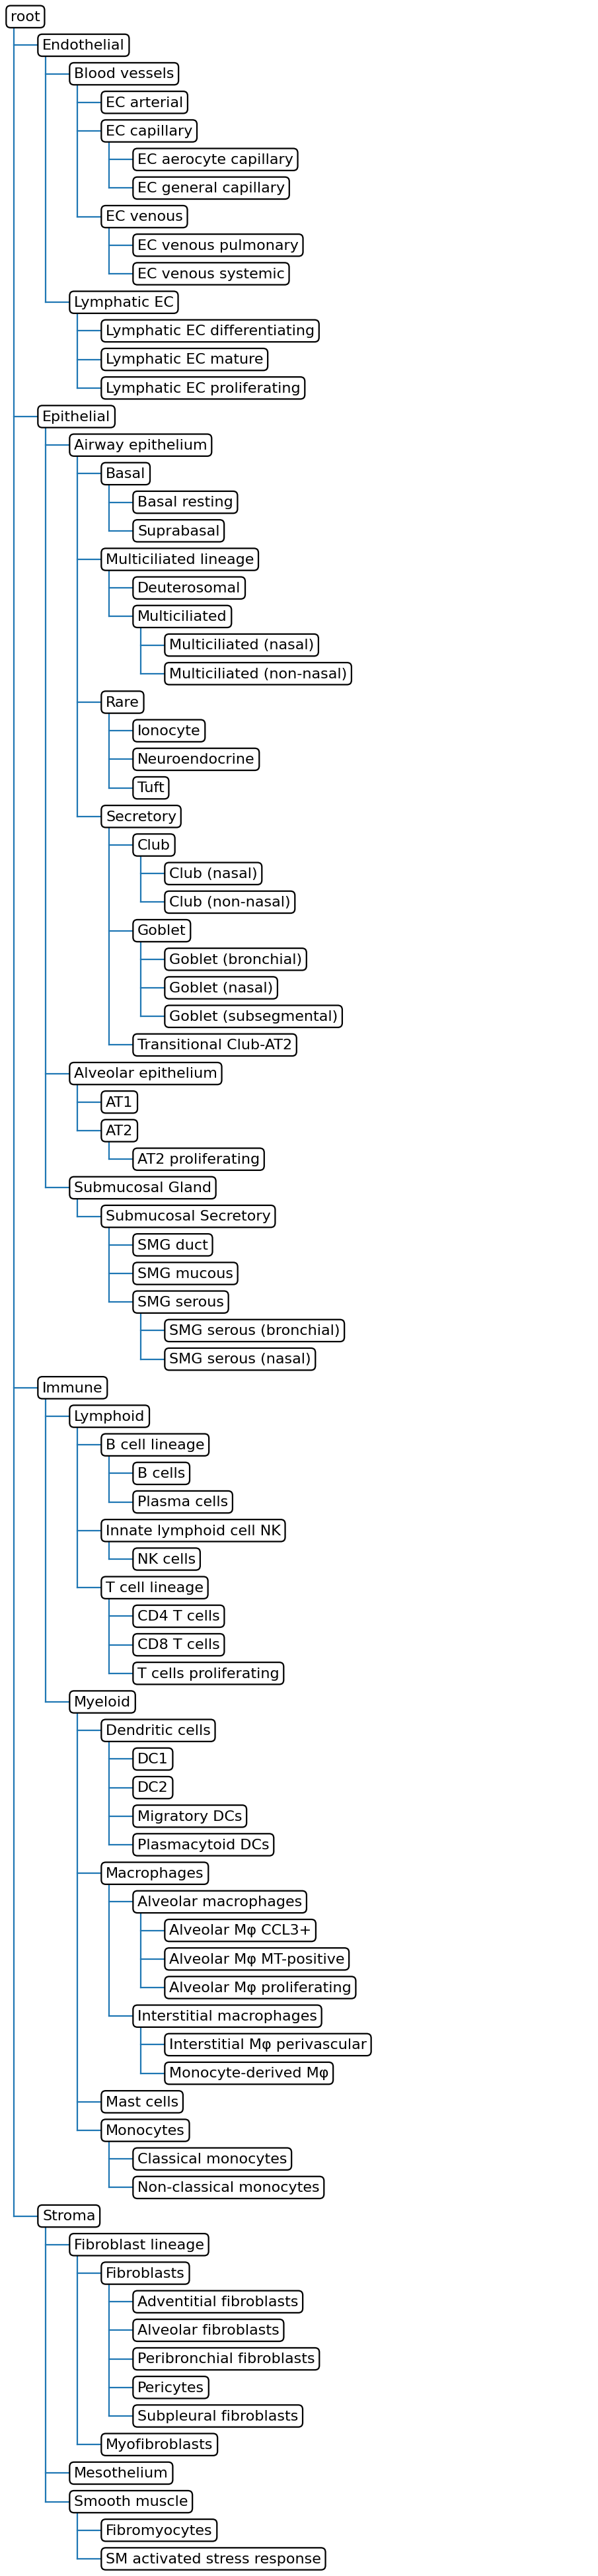


Adding dataset Meyer to the tree
These populations are missing from the tree: 
['B mature-Meyer' 'B naive-Meyer' 'B plasma-Meyer' 'Basal-Meyer'
 'CD4 TRM-Meyer' 'Dividing Basal-Meyer' 'ILC-Meyer' 'MAIT-Meyer'
 'Muscle sm peri sys intermediate-Meyer' 'Muscle smooth pulmonary-Meyer'
 'Muscle smooth syst arterial-Meyer' 'Suprabasal-Meyer']

Updated tree:


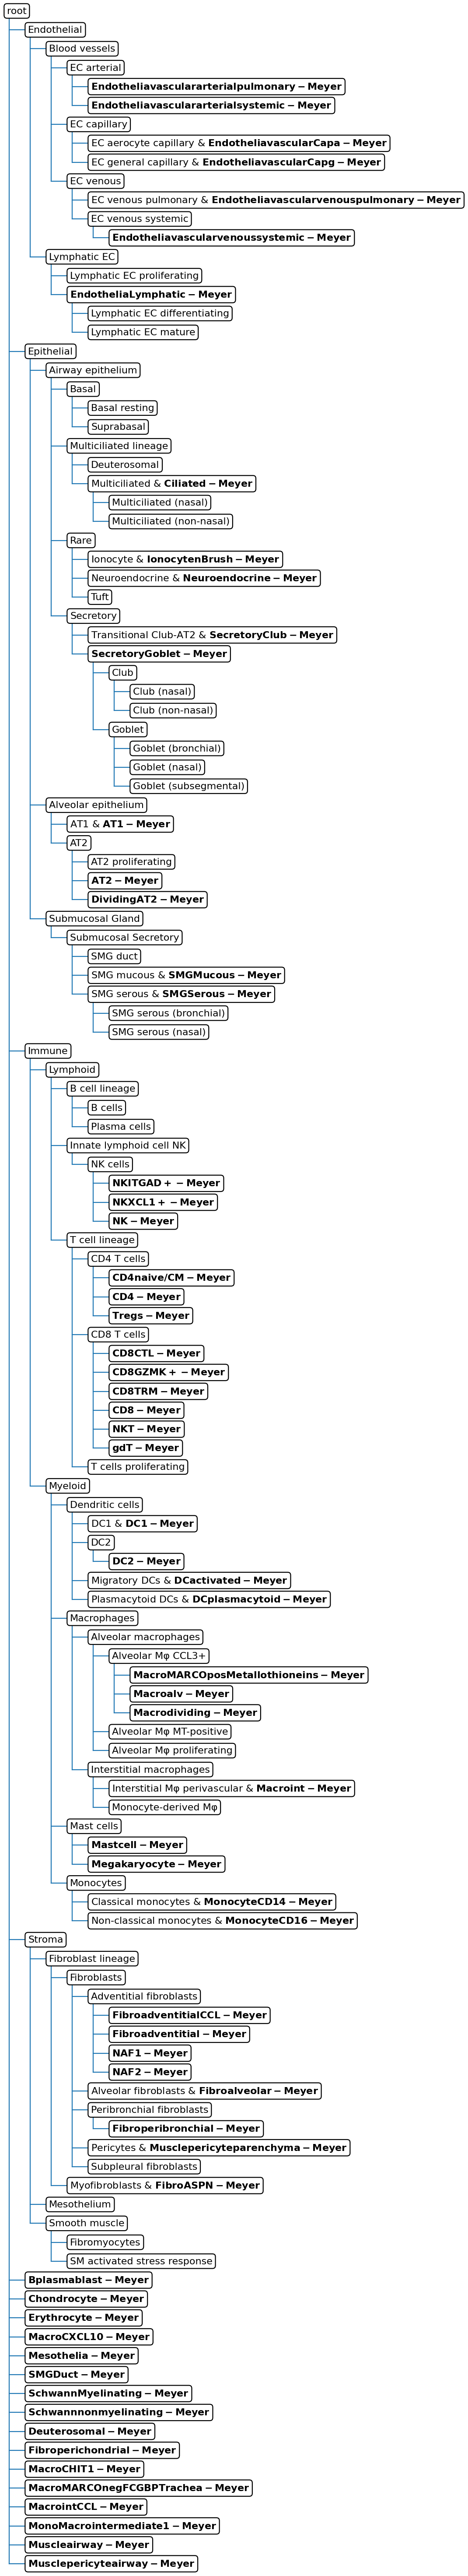

In [26]:
LCA_updated = scHPL.learn.learn_tree(LCA_Meyer, 
                                     batch_key = 'batch',
                                     batch_order = ['Meyer'],
                                     cell_type_key = 'ct-batch',
                                     tree = HLCA_tree,
                                     retrain = False, useRE=True,
                                     batch_added = ['Reference']
                                    )


## 3. Visualizing the latent space + marker genes

In [28]:
sc.pp.neighbors(LCA_Meyer)
sc.tl.leiden(LCA_Meyer)
sc.tl.umap(LCA_Meyer)


In [29]:
LCA.obs['ann_level_2_REF'] = np.char.add(np.char.add(np.array(LCA.obs.ann_level_2, dtype=str), '-'), 'Reference')
LCA_Meyer.obs['ann_level_2'] = LCA.obs.ann_level_2_REF
LCA_Meyer.obs.ann_level_2[LCA_Meyer.obs.ann_level_2.isna()] = 'Meyer'


/tmp/ipykernel_445219/1562560696.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  LCA_Meyer.obs.ann_level_2[LCA_Meyer.obs.ann_level_2.isna()] = 'Meyer'


/exports/humgen/lmichielsen/miniconda3_v2/envs/scarches2/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:1171: FutureWarning: Categorical.replace is deprecated and will be removed in a future version. Use Series.replace directly instead.
  values = values.replace(values.categories.difference(groups), np.nan)


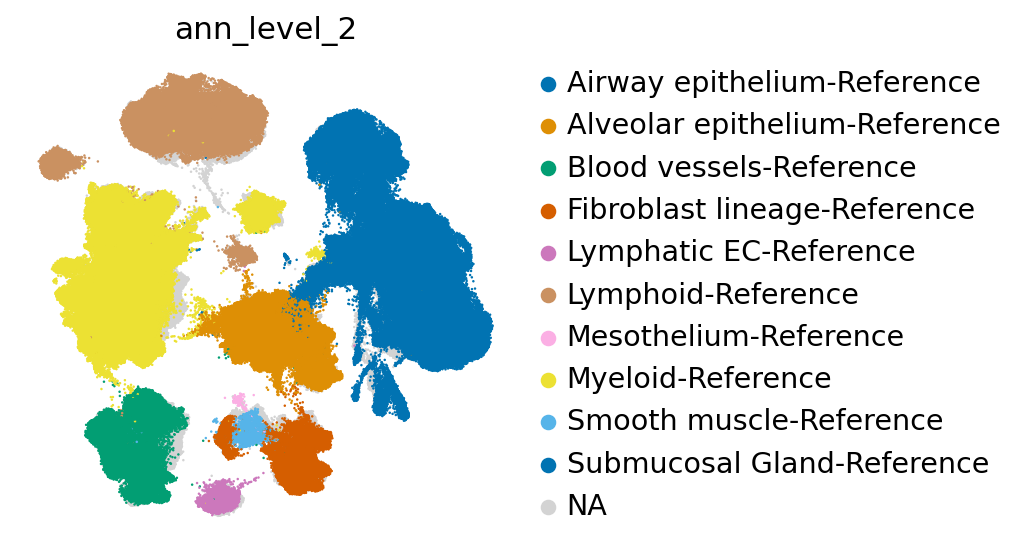

/exports/humgen/lmichielsen/miniconda3_v2/envs/scarches2/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:1171: FutureWarning: Categorical.replace is deprecated and will be removed in a future version. Use Series.replace directly instead.
  values = values.replace(values.categories.difference(groups), np.nan)


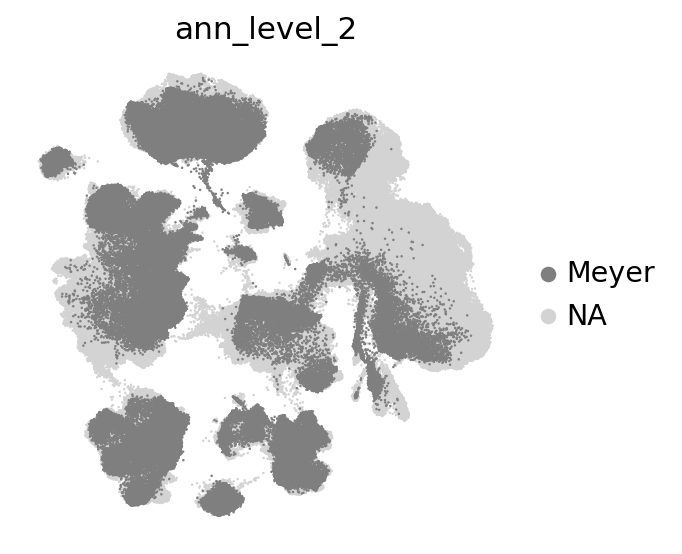

In [30]:
import matplotlib
import seaborn as sns

matplotlib.rcParams['pdf.fonttype'] = 42

sc.pl.umap(LCA_Meyer, color=['ann_level_2'], 
           groups = ['Airway epithelium-Reference', 'Alveolar epithelium-Reference', 
                     'Blood vessels-Reference', 'Fibroblast lineage-Reference',
                     'Lymphatic EC-Reference', 'Lymphoid-Reference',
                     'Mesothelium-Reference', 'Myeloid-Reference',
                     'Smooth muscle-Reference', 'Submucosal Gland-Reference'],
           frameon=False, wspace=0.6, size=5, 
           palette=sns.color_palette('colorblind', as_cmap=True),
           save='_ref_Meyer1.pdf')

sc.pl.umap(LCA_Meyer, color=['ann_level_2'], 
           groups = ['Meyer'], frameon=False,
           wspace=0.6, size=5, palette='tab10',
           save='_ref_Meyer2.pdf'
           )

#### Focus on the endothelial cells (Fig. 3B)

In [31]:
idx_endo = ((LCA_Meyer.obs.ann_level_2 == 'Blood vessels-Reference') | 
            (LCA_Meyer.obs['ct-batch'] == 'Endothelia vascular Cap a-Meyer') | 
            (LCA_Meyer.obs['ct-batch'] == 'Endothelia vascular Cap g-Meyer') | 
            (LCA_Meyer.obs['ct-batch'] == 'Endothelia vascular arterial pulmonary-Meyer') | 
            (LCA_Meyer.obs['ct-batch'] == 'Endothelia vascular arterial systemic-Meyer') | 
            (LCA_Meyer.obs['ct-batch'] == 'Endothelia vascular venous pulmonary-Meyer') | 
            (LCA_Meyer.obs['ct-batch'] == 'Endothelia vascular venous systemic-Meyer'))

LCA_Meyer.obs['subset1'] = '0'
LCA_Meyer.obs['subset1'].values[idx_endo] = '1'

/exports/humgen/lmichielsen/miniconda3_v2/envs/scarches2/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:1171: FutureWarning: Categorical.replace is deprecated and will be removed in a future version. Use Series.replace directly instead.
  values = values.replace(values.categories.difference(groups), np.nan)


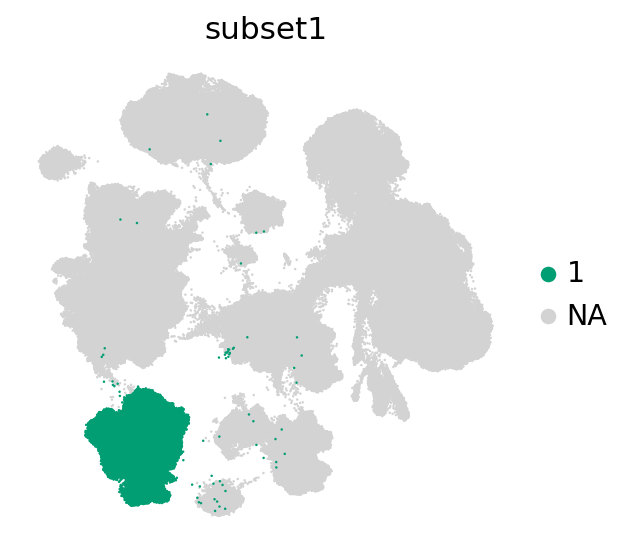

In [32]:
sc.pl.umap(LCA_Meyer,
           color=['subset1'], groups=['1'], 
           frameon=False,
           wspace=0.6, size=5, palette=sns.color_palette('colorblind', as_cmap=True)[1:],
           save='_Meyer_subset1.pdf'
           )


In [33]:
LCA_endo = LCA_Meyer[idx_endo]

In [34]:
sc.pp.neighbors(LCA_endo)
sc.tl.leiden(LCA_endo)
sc.tl.umap(LCA_endo)

In [35]:
# Reorder categories such that the colors will look nices in the umap
LCA_endo.obs['ct-batch'] = LCA_endo.obs['ct-batch'].cat.reorder_categories(['EC aerocyte capillary',  
                                                                          'EC general capillary', 
                                                                          'EC venous pulmonary',
                                                                          'EC venous systemic',
                                                                          'Endothelia vascular venous systemic-Meyer',
                                                                          'EC arterial',
                                                                          'Endothelia vascular arterial pulmonary-Meyer',
                                                                          'Endothelia vascular arterial systemic-Meyer',
                                                                          'Endothelia vascular Cap a-Meyer', 
                                                                          'Endothelia vascular Cap g-Meyer',
                                                                          'Endothelia vascular venous pulmonary-Meyer'])

/exports/humgen/lmichielsen/miniconda3_v2/envs/scarches2/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:1171: FutureWarning: Categorical.replace is deprecated and will be removed in a future version. Use Series.replace directly instead.
  values = values.replace(values.categories.difference(groups), np.nan)


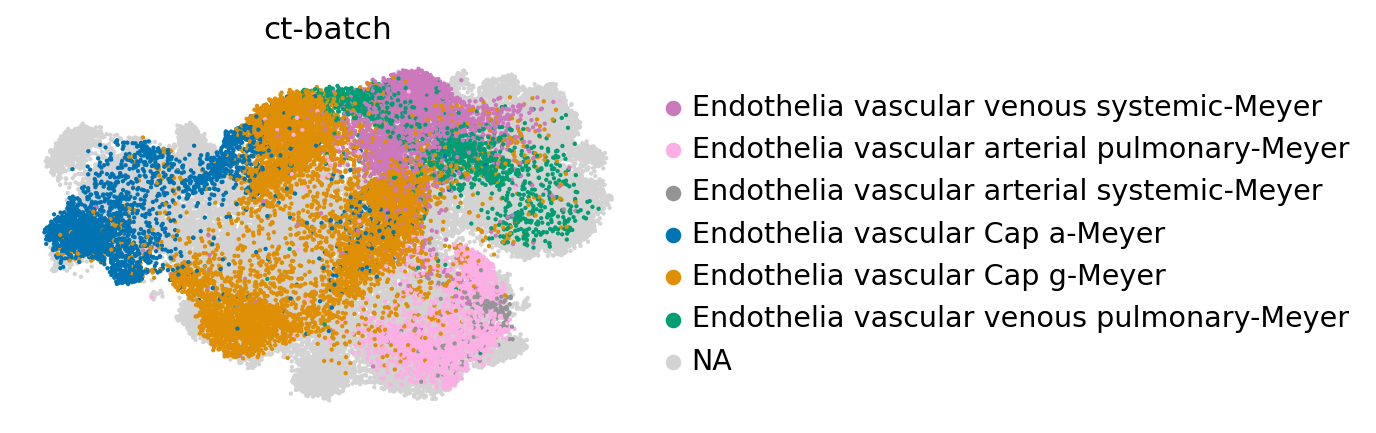

/exports/humgen/lmichielsen/miniconda3_v2/envs/scarches2/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:1171: FutureWarning: Categorical.replace is deprecated and will be removed in a future version. Use Series.replace directly instead.
  values = values.replace(values.categories.difference(groups), np.nan)


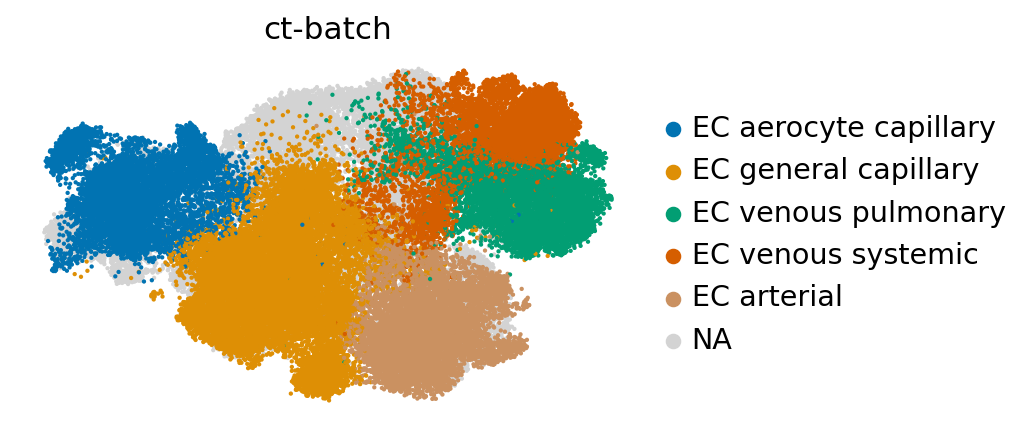

In [36]:
sc.set_figure_params(figsize=(5, 3))

sc.pl.umap(LCA_endo,
           color=['ct-batch'], groups = ['Endothelia vascular Cap a-Meyer', 
                                         'Endothelia vascular Cap g-Meyer',
                                         'Endothelia vascular arterial pulmonary-Meyer',
                                         'Endothelia vascular arterial systemic-Meyer',
                                         'Endothelia vascular venous pulmonary-Meyer',
                                         'Endothelia vascular venous systemic-Meyer'],
           frameon=False,
           wspace=0.6, size=15, palette=sns.color_palette('colorblind', as_cmap=True)[:8],
           save='_ref_Meyer_bloodvessel1.pdf'
           )

sc.pl.umap(LCA_endo,
           color=['ct-batch'], groups = ['EC aerocyte capillary', 
                                         'EC arterial', 
                                         'EC general capillary',
                                         'EC venous pulmonary', 
                                         'EC venous systemic'],
           frameon=False,
           wspace=0.6, size=15, palette=sns.color_palette('colorblind', as_cmap=True)[:8],
           save='_ref_Meyer_bloodvessel2.pdf'
           )

#### Focus on the secretory airway epithelium cells (Fig. 3CD)

In [37]:
idx_air = ((LCA_Meyer.obs['ct-batch'] == 'Club (nasal)') | 
            (LCA_Meyer.obs['ct-batch'] == 'Club (non-nasal)') | 
            (LCA_Meyer.obs['ct-batch'] == 'Secretory Club-Meyer') | 
            (LCA_Meyer.obs['ct-batch'] == 'Secretory Goblet-Meyer') | 
            (LCA_Meyer.obs['ct-batch'] == 'Goblet (bronchial)') | 
            (LCA_Meyer.obs['ct-batch'] == 'Goblet (nasal)') | 
            (LCA_Meyer.obs['ct-batch'] == 'Goblet (subsegmental)') | 
            (LCA_Meyer.obs['ct-batch'] == 'Transitional Club-AT2'))

LCA_Meyer.obs['subset2'] = '0'
LCA_Meyer.obs['subset2'].values[idx_air] = '1'

LCA_air = LCA_Meyer[idx_air]

/exports/humgen/lmichielsen/miniconda3_v2/envs/scarches2/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:1171: FutureWarning: Categorical.replace is deprecated and will be removed in a future version. Use Series.replace directly instead.
  values = values.replace(values.categories.difference(groups), np.nan)


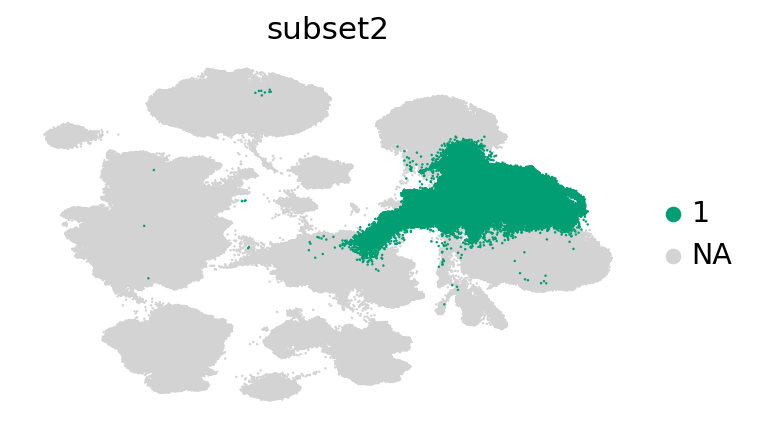

In [38]:
sc.pl.umap(LCA_Meyer,
           color=['subset2'], groups=['1'], 
           frameon=False,
           wspace=0.6, size=5, 
           palette=sns.color_palette('colorblind', as_cmap=True)[1:],
           save='_Meyer_subset2.pdf'
           )


In [39]:
sc.pp.neighbors(LCA_air)
sc.tl.leiden(LCA_air)
sc.tl.umap(LCA_air)


In [40]:
LCA_air.obs['ct-batch'] = LCA_air.obs['ct-batch'].cat.reorder_categories(['Transitional Club-AT2', 'Club (nasal)', 'Club (non-nasal)', 'Goblet (bronchial)',
       'Goblet (nasal)', 'Goblet (subsegmental)', 'Secretory Goblet-Meyer', 'Secretory Club-Meyer' ])

/exports/humgen/lmichielsen/miniconda3_v2/envs/scarches2/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:1171: FutureWarning: Categorical.replace is deprecated and will be removed in a future version. Use Series.replace directly instead.
  values = values.replace(values.categories.difference(groups), np.nan)


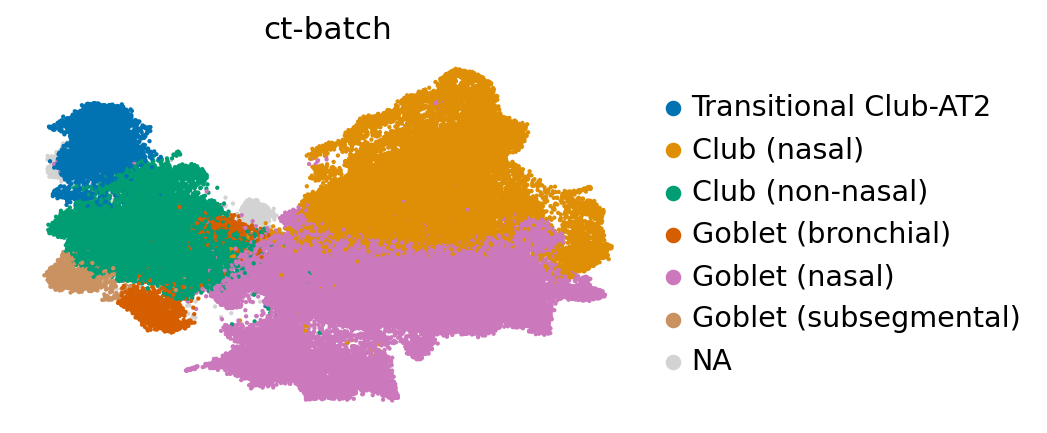

/exports/humgen/lmichielsen/miniconda3_v2/envs/scarches2/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:1171: FutureWarning: Categorical.replace is deprecated and will be removed in a future version. Use Series.replace directly instead.
  values = values.replace(values.categories.difference(groups), np.nan)


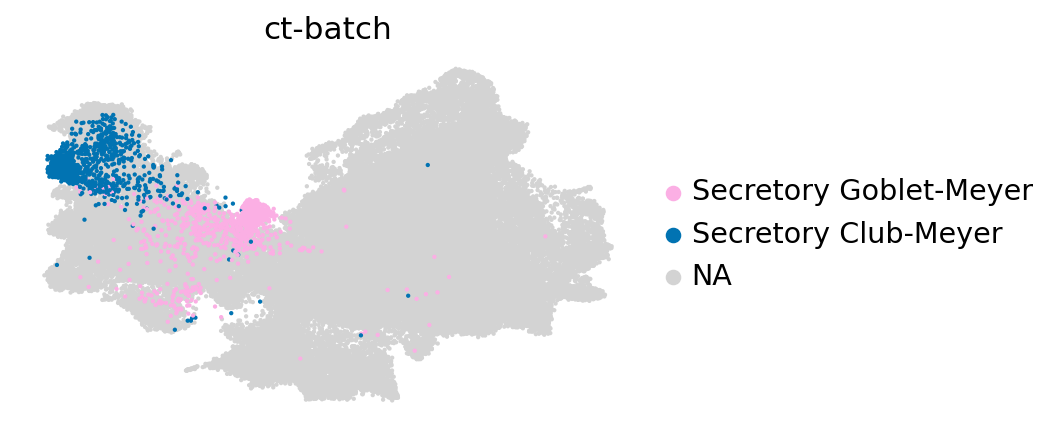

In [41]:
sc.set_figure_params(figsize=(5, 3))

sc.pl.umap(LCA_air,
           color=['ct-batch'], groups=['Club (nasal)',
       'Club (non-nasal)', 'Goblet (bronchial)', 'Goblet (nasal)',
       'Goblet (subsegmental)', 
       'Transitional Club-AT2'],
           frameon=False,
           wspace=0.6, size=15, palette=sns.color_palette('colorblind', as_cmap=True)[:7],
           save='_ref_Meyer_clubgoblet1.pdf'
           )

sc.pl.umap(LCA_air,
           color=['ct-batch'], groups = ['Secretory Club-Meyer', 'Secretory Goblet-Meyer'] ,
           frameon=False,
           wspace=0.6, size=15, palette=sns.color_palette('colorblind', as_cmap=True)[:7],
           save='_ref_Meyer_clubgoblet2.pdf'
           )

For the club and goblet cells, we will visualize marker genes. For this, we need the count data for the reference. This can be downloaded here: https://cellxgene.cziscience.com/collections/6f6d381a-7701-4781-935c-db10d30de293 

In [43]:
data_LCA = sc.read_h5ad('local.h5ad')

In [44]:
sc.pp.normalize_total(data_M)
sc.pp.log1p(data_M)

/exports/humgen/lmichielsen/miniconda3_v2/envs/scarches2/lib/python3.8/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [70]:
data_LCA.var_names = data_LCA.var['feature_name']

/exports/humgen/lmichielsen/miniconda3_v2/envs/scarches2/lib/python3.8/site-packages/anndata/_core/anndata.py:895: UserWarning: 
AnnData expects .var.index to contain strings, but got values like:
    ['TSPAN6', 'TNMD', 'DPM1', 'SCYL3', 'C1orf112']

    Inferred to be: categorical

  names = self._prep_dim_index(names, "var")


In [63]:
data_all = sc.concat([data_LCA, data_M])


/exports/humgen/lmichielsen/miniconda3_v2/envs/scarches2/lib/python3.8/site-packages/anndata/_core/merge.py:942: UserWarning: Only some AnnData objects have `.raw` attribute, not concatenating `.raw` attributes.
  warn(


In [64]:
data_air = data_all[LCA_air.obs_names]
data_air.obs = LCA_air.obs
data_air.obsm = LCA_air.obsm

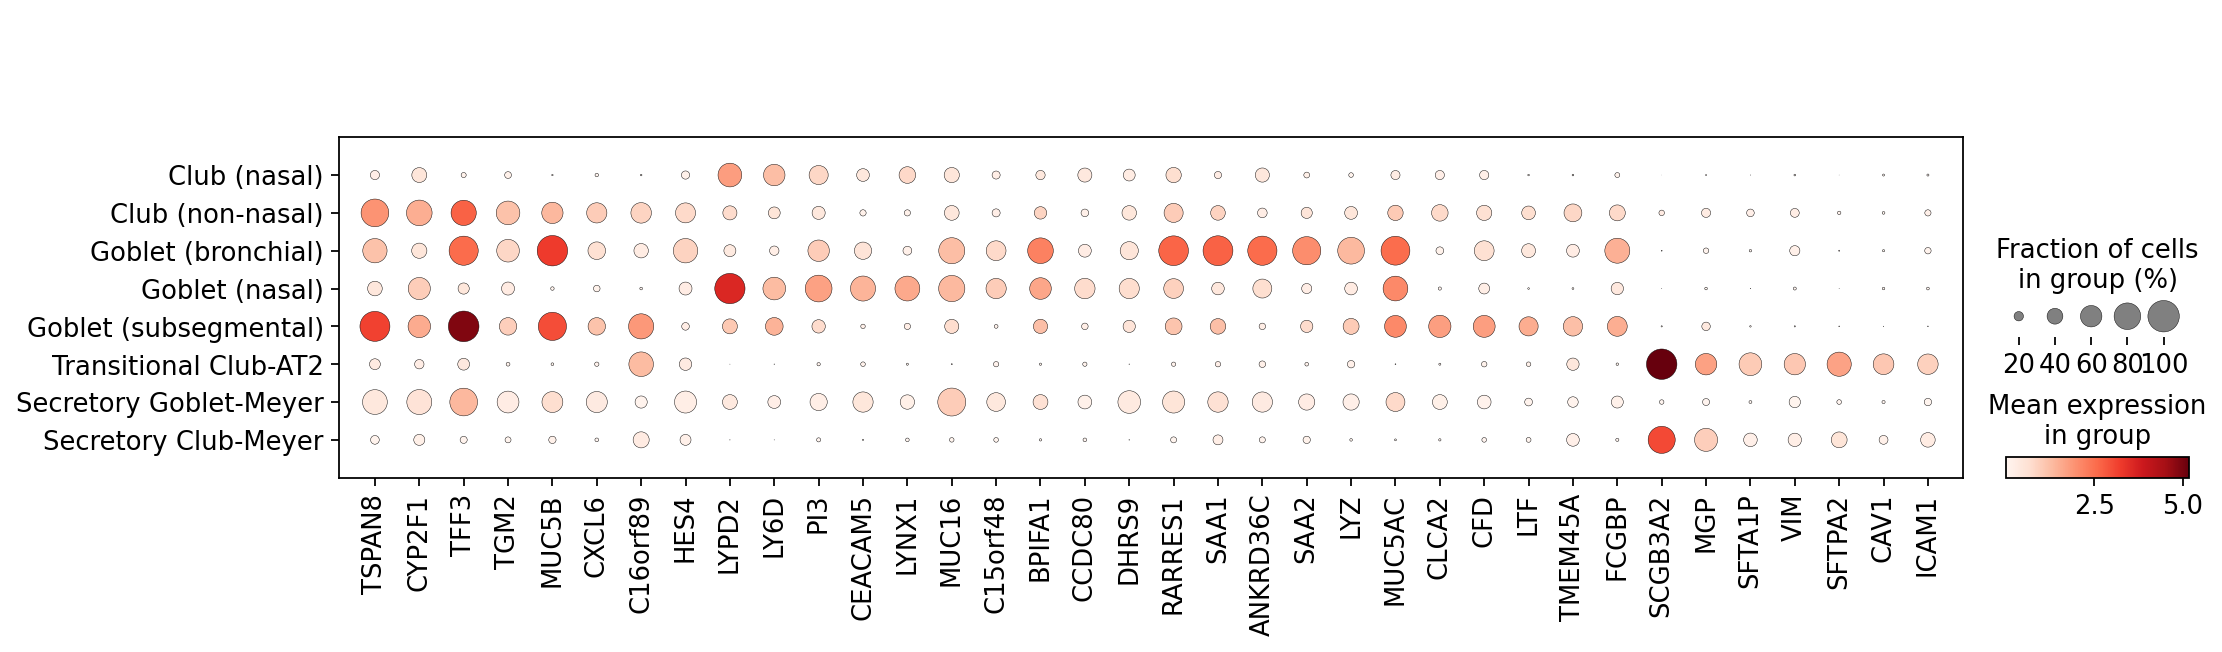

In [66]:
# Club (non-nasal)['TSPAN8','CYP2F1','TFF3','TGM2','MUC5B','CXCL6','C16orf89','HES4','RHOV','KIAA1324']
# Club (nasal)['ASRGL1','LYPD2','UGT2A1','TFCP2L1','LY6D','TPD52L1','SORD','PI3']
# Goblet (nasal)['LYPD2','PI3','CEACAM5','LYNX1','MUC5AC','MUC16','C15orf48','BPIFA1','CCDC80','DHRS9']
# Goblet (bronchial)['MUC5B','RARRES1','SAA1','ANKRD36C','SAA2','LYZ','PLCG2','FCGBP','RIMS1','MUC5AC']
# Goblet (subsegmental)['TSPAN8','MUC5B','C16orf89','MTRNR2L10','CLCA2','CFD','KIAA1324','LTF','TMEM45A','FCGBP']
# Transitional Club-AT2['SCGB3A2','MGP','C16orf89','SFTA1P','VIM','SFTPA2','CAV1','ICAM1','SUSD2']

sc.pl.dotplot(data_air,['TSPAN8','CYP2F1','TFF3','TGM2','MUC5B','CXCL6','C16orf89','HES4',
                        'LYPD2','LY6D',
                        'PI3','CEACAM5','LYNX1','MUC16','C15orf48','BPIFA1','CCDC80','DHRS9',
                        'RARRES1','SAA1','ANKRD36C','SAA2','LYZ','MUC5AC',
                        'CLCA2','CFD','LTF','TMEM45A','FCGBP',
                        'SCGB3A2','MGP','SFTA1P','VIM','SFTPA2','CAV1','ICAM1'], 
              groupby='ct-batch',
              categories_order=['Club (nasal)', 'Club (non-nasal)', 'Goblet (bronchial)',
                                'Goblet (nasal)', 'Goblet (subsegmental)', 'Transitional Club-AT2', 
                                'Secretory Goblet-Meyer', 'Secretory Club-Meyer',],
              save='club_goblet_all.pdf'
             )


#### Focus on the macrophages (Fig. S7)

In [67]:
### Select macrophages
LCA_Meyer.obs['ann_level_3'] = 'Meyer'
LCA_Meyer.obs['ann_level_3'].loc[LCA.obs_names] = LCA.obs['ann_level_3']
idx_macro = (LCA_Meyer.obs['ann_level_3'] == 'Macrophages') | (np.isin(LCA_Meyer.obs['ct-batch'], ['Macro CHIT1-Meyer', 'Macro CXCL10-Meyer',
       'Macro MARCOneg FCGBP Trachea-Meyer',
       'Macro MARCOpos Metallothioneins-Meyer', 'Macro alv-Meyer',
       'Macro dividing-Meyer', 'Macro int CCL-Meyer', 'Macro int-Meyer']))

data_macro = data_all[idx_macro]
LCA_macro = LCA_Meyer[idx_macro]


/tmp/ipykernel_445219/1683122918.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  LCA_Meyer.obs['ann_level_3'].loc[LCA.obs_names] = LCA.obs['ann_level_3']


In [68]:
data_macro.obs['ct-batch'] = LCA_macro.obs['ct-batch']

/tmp/ipykernel_445219/1227286949.py:1: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  data_macro.obs['ct-batch'] = LCA_macro.obs['ct-batch']


Meyer


/exports/humgen/lmichielsen/miniconda3_v2/envs/scarches2/lib/python3.8/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


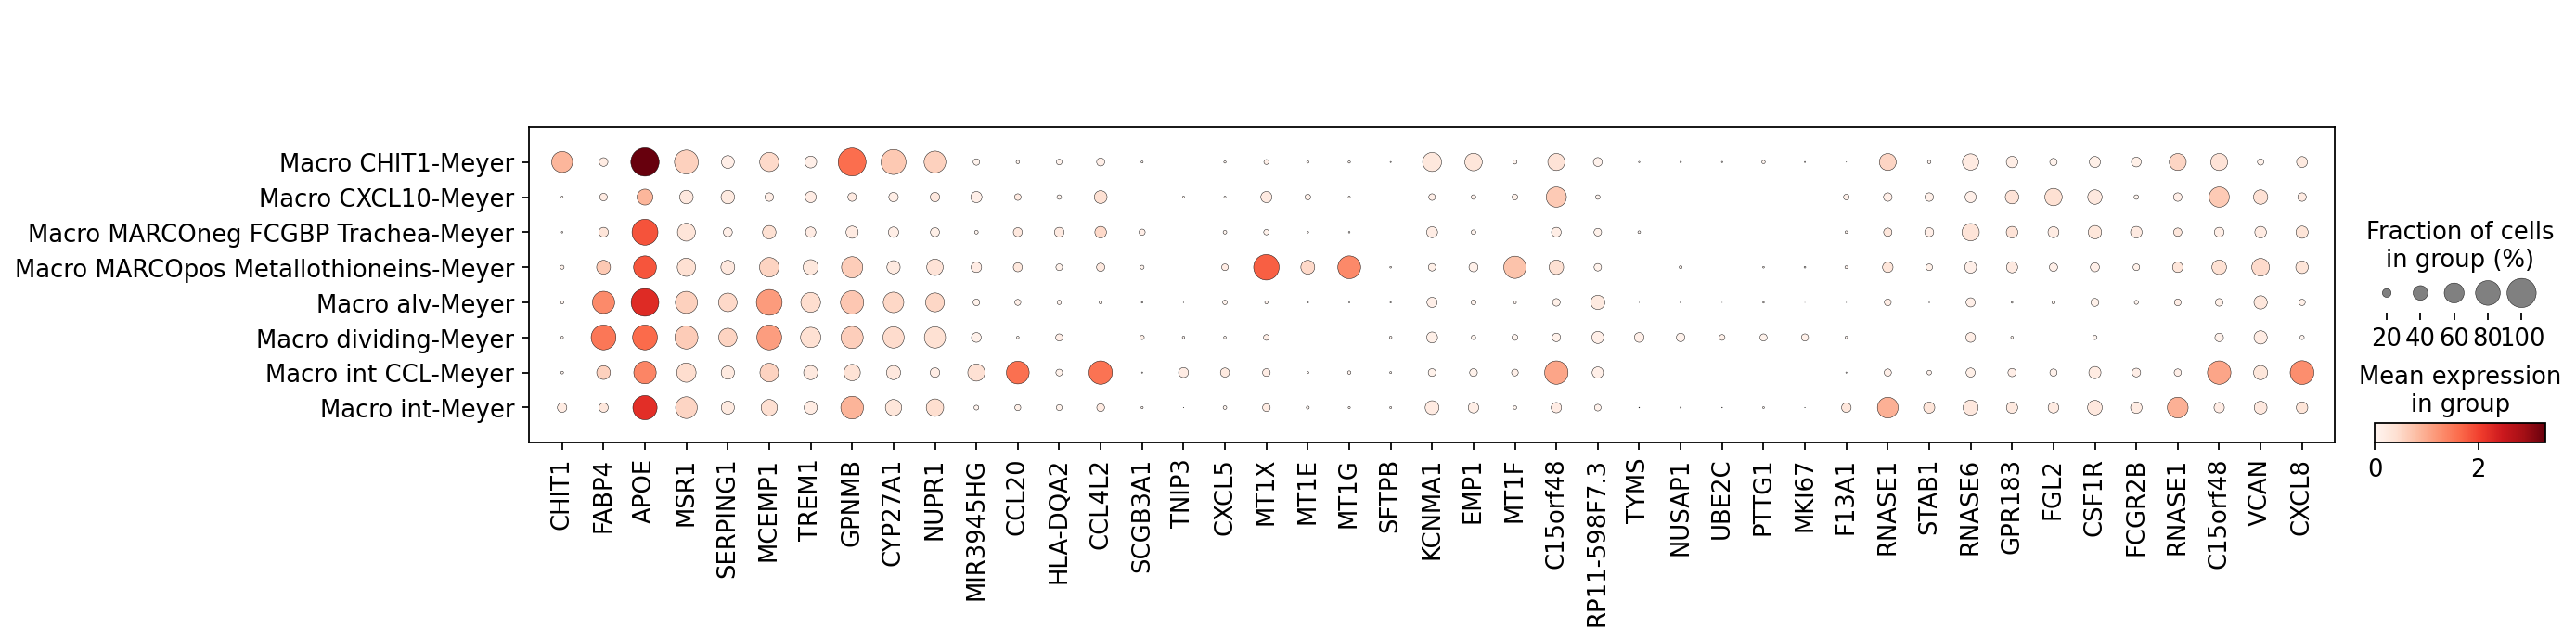

Reference


/exports/humgen/lmichielsen/miniconda3_v2/envs/scarches2/lib/python3.8/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/exports/humgen/lmichielsen/miniconda3_v2/envs/scarches2/lib/python3.8/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/exports/humgen/lmichielsen/miniconda3_v2/envs/scarches2/lib/python3.8/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/exports/humgen/lmichielsen/miniconda3_v2/envs/scarches2/lib/python3.8/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


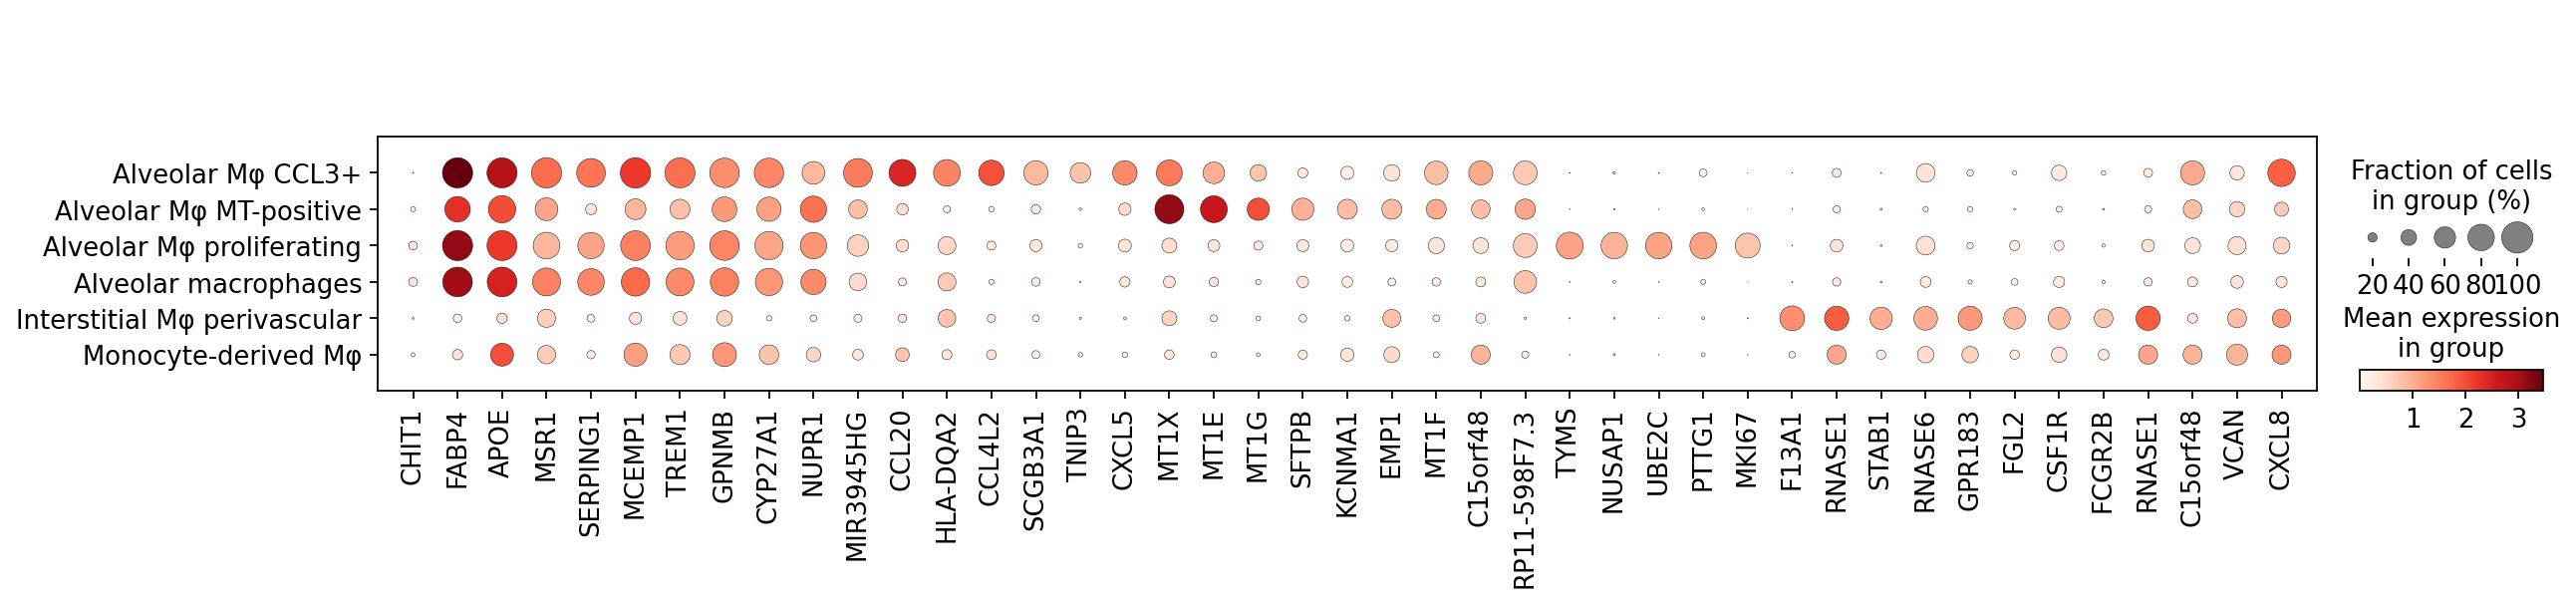

In [69]:
# Macro CHIT1 (Meyer): 'CHIT1', 
# Alveolar: 'FABP4', 'APOE', 'MSR1', 'SERPING1', 'MCEMP1', 'TREM1', 'GPNMB', 'CYP27A1', 'NUPR1',
# Alveolar CCL3+: 'MIR3945HG', 'CCL20','HLA-DQA2','CCL4L2','SCGB3A1','TNIP3','CXCL5',
# Alveolar MT-positive: 'MT1X','MT1E','MT1G','SFTPB','KCNMA1','EMP1','MT1F','C15orf48','RP11-598F7.3',
# Alveolar proliferating: 'TYMS','NUSAP1','UBE2C','PTTG1','MKI67',
# Interstitial perivascular: 'F13A1','RNASE1','STAB1','RNASE6','GPR183','FGL2','CSF1R','FCGR2B',
# MdM: 'RNASE1','C15orf48','VCAN','CXCL8'

for b in np.unique(LCA_macro.obs.batch):
    idx = np.where(LCA_macro.obs.batch == b)[0]
    print(b)
    sc.pl.dotplot(data_macro[idx], ['CHIT1', 
                                    'FABP4', 'APOE', 'MSR1', 'SERPING1', 'MCEMP1', 'TREM1', 'GPNMB', 'CYP27A1', 'NUPR1',
                                    'MIR3945HG', 'CCL20','HLA-DQA2','CCL4L2','SCGB3A1','TNIP3','CXCL5',
                                   'MT1X','MT1E','MT1G','SFTPB','KCNMA1','EMP1','MT1F','C15orf48','RP11-598F7.3',
                                   'TYMS','NUSAP1','UBE2C','PTTG1','MKI67',
                                   'F13A1','RNASE1','STAB1','RNASE6','GPR183','FGL2','CSF1R','FCGR2B',
                                   'RNASE1','C15orf48','VCAN','CXCL8'], 
                  groupby='ct-batch', save='_macro_CHIT1_' + b + '.pdf')
